-- PROGRAMMING FOR DATA ANALYTICS : Efficient KAN__


__Author    : Clyde Watts__  
__Lecturer : Andrew Beaty__  
__Date      : 2025-11-20__



https://www.sciencedirect.com/science/article/pii/S030626192402227X?via%3Dihub

In [237]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import seaborn as sns
import datetime as datetime

## Import Efficient KAN Library

Imports the efficient-kan library which provides an optimized KAN implementation.

**Installation**: `pip install git+https://github.com/Blealtan/efficient-kan.git`

**Key Differences from PyKAN:**
- More memory efficient implementation
- Uses standard PyTorch training loop instead of custom fit() method
- Simpler API with focus on performance

**Reference:**
- [Efficient KAN GitHub Repository](https://github.com/Blealtan/efficient-kan)



In [ ]:
from efficient_kan import KAN


## Define Feature Visualization Function

This function visualizes how KAN learns the relationship between individual features and the target variable:

**How it works:**
1. Creates synthetic input with all features at their mean values
2. Varies only the target feature across its range
3. Passes through the trained KAN model
4. Plots the learned transformation function

**Why is this useful?**
Unlike traditional neural networks (black boxes), KAN models reveal the mathematical relationship they've learned for each feature. This provides **interpretability** - we can see if the model learned physically meaningful relationships.

**Example**: If temperature increases, does solar output increase/decrease? The plot shows this relationship.

**Reference:**
- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)


In [239]:
import matplotlib.pyplot as plt
import torch
import numpy as np
target_col = 'PW(V)'

def plot_kan_feature(model, feature_name, feature_cols, X_train, scaler_X,target_col=target_col):
    """
    Plots the specific learned function (Physical Law) for a given feature.
    
    Args:
        model: The trained KAN model
        feature_name (str): The exact name of the column to plot (e.g. 'Wind Cooling')
        feature_cols (list): The list of all feature names used in training
        X_train (numpy array): The RAW (unscaled) training data (for calculating means/ranges)
        scaler_X (StandardScaler): The fitted scaler used to transform the data
    """
    
    # 1. Find the index
    try:
        feature_index = feature_cols.index(feature_name)
    except ValueError:
        print(f"❌ ERROR: '{feature_name}' not found in feature list.")
        return

    # 2. Setup Dimensions
    input_dim = X_train.shape[1]
    
    # 3. Create Synthetic Data (Base = Mean of everything)
    # We use 100 points for a smooth curve
    dummy_input_raw = np.zeros((100, input_dim))
    
    for i in range(input_dim):
        # Fill every column with its AVERAGE value from the real world
        # This isolates the feature we care about
        dummy_input_raw[:, i] = np.mean(X_train[:, i])

    # 4. Vary the Target Feature
    min_val = np.min(X_train[:, feature_index])
    max_val = np.max(X_train[:, feature_index])
    seq_values = np.linspace(min_val, max_val, 100)
    
    dummy_input_raw[:, feature_index] = seq_values

    # 5. Scale & Predict
    # The model speaks "Scaled", so we translate our raw numbers
    dummy_input_scaled = scaler_X.transform(dummy_input_raw)
    dummy_tensor = torch.from_numpy(dummy_input_scaled).float()

    model.eval()
    with torch.no_grad():
        predictions = model(dummy_tensor)
    
    # Flatten for plotting
    preds_flat = predictions.numpy().flatten()

    # 6. Plot
    plt.figure(figsize=(4, 2))
    plt.plot(seq_values, preds_flat, color='#007acc', linewidth=3, label='KAN Learned Law')
    
    # Formatting
    plt.title(f"Effect of {feature_name}", fontsize=14)
    plt.xlabel(f"{feature_name} (Physical Units)", fontsize=12)
    plt.ylabel(f"{target_col} (Efficiency)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add Reference Line
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label="100% Efficiency")
    
    # Add "Slope Arrow" to show direction
    if preds_flat[-1] > preds_flat[0]:
        color = 'green'
        msg = "Positive Impact"
    else:
        color = 'orange'
        msg = "Negative Impact"
        
    dx = max_val - min_val
    dy = preds_flat[-1] - preds_flat[0]
    # Only draw arrow if there is a significant change
    if abs(dy) > 0.05:
        plt.arrow(min_val, preds_flat[0], dx, dy, color=color, alpha=0.5, width=0.005)
        plt.text(min_val, preds_flat[-1], msg, color=color, fontweight='bold')

    plt.legend()
    plt.show()

## Configure File Paths and Solar Parameters

Identical to the ANN notebook, this sets up:
- Directory paths for data and models
- Solar panel configuration (19 panels, 8,360W total capacity)
- Location coordinates (Bettystown, Ireland)

See the ANN notebook for detailed explanation of these parameters.


In [240]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
MODEL_DIR = f'{HOME_DIR}/model/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'

# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


## Set Nighttime Threshold

Filters out nighttime data where Clear Sky GHI ≤ 50 W/m². 

Only daytime data with meaningful solar radiation is used for training.


In [241]:
hourly_nighlty_threshold = 50

## Load and Filter Solar Data

Loads hourly solar data and removes nighttime records.

**Note the typo**: `hourly_nighlty_threshold` should be `hourly_nightly_threshold` (doesn't affect functionality).


In [242]:
df_merge_hourly = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_full_data.feather")

# Remove all rows where Clear sky GHI is less than or equal to 50
df_merge_hourly = df_merge_hourly[df_merge_hourly['Clear sky GHI'] > hourly_nighlty_threshold]


## Extract Weather Condition Features

Extracts one-hot encoded weather features:
- **Level 1**: Specific conditions (clear, cloudy, rain, fog, etc.)
- **Level 2**: Broader categories (visibility, precipitation, severe weather)

These help KAN understand weather impacts on solar output.


In [243]:
level1_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level2_')]

## Define Target Variable and Features

**This cell is empty but typically would:**
- Define the target variable (PV(W), Clearsky_Index, or error terms)
- Select input features
- Remove irrelevant columns

The actual feature selection appears to happen in a later cell.


In [244]:

display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))

,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Additional Feature Engineering

**This cell appears empty** - likely placeholder or contains whitespace.


In [245]:

feature_cols = []
test_no="999"
# Define test parameters
test_no = 1  # Increment this for each test run
test_name = f"No Name - Target {target_col}"
notes = ""  # Add any notes about this test run

# Define target column

#target_col = 'PV(W)'
# Kan Prefers Clearsky_Index
target_col = 'Clearsky_Index'
#target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
#feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
#feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
feature_cols.append('Power_ClearSky_Pane_I(W)')
feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
##feature_cols.append('Month_Cos')
##feature_cols.append('DayOfYear_Cos')
##feature_cols.append('HourOfDay_Cos')
##feature_cols.append('Dew Point(C)_Lag1')
##feature_cols.append('Temp_Lag1')
##feature_cols.append('Humidity_Lag1')
##feature_cols.append('WindSpeed_Lag1')
##feature_cols.append('Dew Point(C)_Lag24')
##feature_cols.append('Temp_Lag24')
##feature_cols.append('Humidity_Lag24')
##feature_cols.append('WindSpeed_Lag24')
##feature_cols.append('Total_Power_ClearSky_Output(W)_Lag1')
##feature_cols.append('Total_Power_ClearSky_Output(W)_Lag24')
# Wind direction as sin and cos
##feature_cols.append('WindDir_Sin')
##feature_cols.append('WindDir_Cos')

#  level2_features
##feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting KAN with target: {target_col} and features: {feature_cols}")

# remove any duplicate features
feature_cols = list(set(feature_cols))
print(f"Final feature list (duplicates removed): {feature_cols}")
# check if all feature columns exist in the dataframe
missing_features = [col for col in feature_cols if col not in df_merge_hourly.columns]
if missing_features:
    print(f"❌ ERROR: The following feature columns are missing from the dataframe: {missing_features}")
else:
    print("✅ All feature columns are present in the dataframe.")



Testing KAN with target: Clearsky_Index and features: ['Temperature(C)', 'Humidity(%)', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
Final feature list (duplicates removed): ['Total_Power_ClearSky_Output(W)', 'Power_ClearSky_Pane_I(W)', 'Wind Cooling', 'Wind Gust(m/s)', 'HourOfDay_Sin', 'DayOfYear_Sin', 'Power_ClearSky_Pane_II(W)', 'Humidity(%)', 'Pressure(hPa)', 'WeekOfYear', 'Month_Sin', 'Dew Point(C)', 'Precipitation(mm)', 'Temperature(C)', 'Wind Speed(m/s)']
✅ All feature columns are present in the dataframe.


## Data Splitting and Scaling

**This cell appears empty** - the actual data preparation likely happens in a later cell not shown in this view.


In [246]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


## More Data Preparation

**This cell appears empty** - continuing data preparation steps.


In [247]:

# ==========================================
# 1. Prepare Data (Using your winning "Error" target)
# ==========================================

# Assuming 'df' is your DataFrame and we want to predict 'PV_Error'
# Define your features (X) and target (y)
features = feature_cols
target_col = target_col

# Drop NaNs
model_df = df_merge_hourly.dropna(subset=features + [target_col])
X = model_df[features].values
y = model_df[target_col].values.reshape(-1, 1)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=False)
#from sklearn.model_selection import TimeSeriesSplit

#tscv = TimeSeriesSplit(n_splits=5)
#for train_index, test_index in tscv.split(X):
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#    # Train and evaluate your KAN or XGBoost model here

# Train on even weeks, Test on odd weeks
train_df = df_merge_hourly[df_merge_hourly['WeekOfYear'] % 2 == 0]
test_df = df_merge_hourly[df_merge_hourly['WeekOfYear'] % 2 != 0]

X_train, y_train = train_df[feature_cols].values, train_df[target_col].values.reshape(-1, 1)
X_test, y_test = test_df[feature_cols].values, test_df[target_col].values.reshape(-1, 1)

# Normalize (Neural Networks LOVES scaled data)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Create dataset dictionary for KAN model
# KAN expects keys: 'train_input', 'train_label', 'test_input', 'test_label'
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train_scaled).float()
dataset['train_label'] = torch.from_numpy(y_train).float()
dataset['test_input'] = torch.from_numpy(X_test_scaled).float()
dataset['test_label'] = torch.from_numpy(y_test).float()


## Prepare KAN Model Input

This cell likely:
1. Creates train/test split
2. Standardizes features
3. Converts data to PyTorch tensors
4. Organizes into a dataset dictionary for KAN

**KAN Input Format**: KAN models require specific data formatting with train/test inputs and labels.


In [248]:
input_dim = X_train.shape[1]



__Using Standard PyTorch Training Loop__

- **Training loop** - Standard PyTorch training with Adam optimizer
- **Regularization** - L1 regularization on weights to encourage sparsity
- **Evaluation** - Continuous monitoring of train and test losses

Unlike the pykan implementation which uses custom fit() and prune() methods,
efficient-kan uses the standard PyTorch training paradigm for better flexibility
and compatibility with existing PyTorch tools.

**Reference:**
- [Efficient KAN GitHub](https://github.com/Blealtan/efficient-kan)


In [ ]:
# ==========================================
# 2. Define & Train the Efficient KAN
# ==========================================

import torch.optim as optim

# Initialize Efficient KAN
# layers_hidden: [input_dim, hidden_dim, output_dim]
# grid_size: granularity of the spline grid (similar to 'grid' in pykan)
# spline_order: order of the spline (k=3 is cubic)
input_dim = X_train.shape[1]
print(f"Input dimension for KAN: {input_dim}")

model = KAN(
    layers_hidden=[input_dim, 7, 1],  # layers architecture
    grid_size=12,  # Number of control points
    spline_order=3,  # order of equation
    scale_noise=0.1,
    scale_base=1.0,
    scale_spline=1.0,
    base_activation=torch.nn.SiLU,
    grid_eps=0.02,
    grid_range=[-1, 1]
).to(device)

print("Starting Efficient KAN Training (using Adam optimizer)...")
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

# Setup optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Convert data to tensors if not already
train_input = dataset['train_input'].to(device)
train_label = dataset['train_label'].to(device)
test_input = dataset['test_input'].to(device)
test_label = dataset['test_label'].to(device)

# Training loop
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(train_input)
    
    # Compute loss with regularization
    loss = criterion(predictions, train_label)
    reg_loss = model.regularization_loss(regularize_activation=1.0, regularize_entropy=2.0)
    total_loss = loss + 0.001 * reg_loss
    
    # Backward pass
    total_loss.backward()
    optimizer.step()
    
    # Test phase
    model.eval()
    with torch.no_grad():
        test_predictions = model(test_input)
        test_loss = criterion(test_predictions, test_label)
    
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Store results for plotting
results = {'train_loss': train_losses, 'test_loss': test_losses}
print("\nTraining completed!")




(Stuff)[https://www.codecademy.com/article/getting-more-out-of-jupyter-notebook]
()[https://www.mdpi.com/2079-9292/14/6/1161]

In [ ]:
# Note: Efficient KAN does not have built-in symbolic representation
# The model focuses on efficiency rather than interpretability features
# However, the learned relationships can still be visualized through the
# plot_kan_feature function


__Symbolic Represetation Of Formula__

There is an issue with the library deriving the formulae associated with the node.

In [251]:

def convert_to_pvw(y_pred, y_true, target_col, clearsky_values):
    """Convert predictions to PV(W) based on target column type"""
    if target_col == 'PV(W)':
        # Already in PV(W), no conversion needed
        return y_pred.copy(), y_true.copy()
    elif target_col == 'Clearsky_Index':
        # PV(W) = Clearsky_Index * Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred * clearsky_values
        y_true_pvw = y_true * clearsky_values
    elif target_col == 'PV(W)_error':
        # PV(W) = PV(W)_error + Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred + clearsky_values
        y_true_pvw = y_true + clearsky_values
    elif target_col == 'PV(W)_error_index':
        # PV(W) = PV(W)_error_index * Total_Power_ClearSky_Output(W) + Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred * clearsky_values + clearsky_values
        y_true_pvw = y_true * clearsky_values + clearsky_values
    else:
        raise ValueError(f"Unknown target column: {target_col}")
    
    # Apply physics constraints (no negative power output)
    y_pred_pvw = np.clip(y_pred_pvw, 0, None)
    y_true_pvw = np.clip(y_true_pvw, 0, None)
    
    return y_pred_pvw, y_true_pvw



In [252]:

# Convert predictions and actual values to PV(W)
y_pred_test_pvw, y_test_pvw = convert_to_pvw(y_pred_test, y_test, target_col, clearsky_test)
y_pred_train_pvw, y_train_pvw = convert_to_pvw(y_pred_train, y_train, target_col, clearsky_train)


## Model Evaluation and Convergence Check

This cell likely:
1. Checks if training converged
2. Evaluates R² score
3. Verifies model performance before further analysis

**Convergence**: Indicates the model has learned stable relationships.


In [ ]:
# 3. Check for Convergence
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Training Progress: Loss over Epochs")
plt.plot(results['train_loss'], label='Train Loss', linewidth=2)
plt.plot(results['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [254]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do XBOOST regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


# do XBOOST regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    normalization_factor = np.max(y_true) - np.min(y_true)
    #normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    # Calculate Explained Variance
    explained_var = explained_variance_score(y_true, y_pred)
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score, explained_var

y_pred_test_pvw, y_test_pvw = convert_to_pvw(y_pred_test, y_test, target_col, clearsky_test)
y_pred_train_pvw, y_train_pvw = convert_to_pvw(y_pred_train, y_train, target_col, clearsky_train)

train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy, train_explained_var = calculate_metrics(y_train, y_pred_train)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy, test_explained_var = calculate_metrics(y_test, y_pred_test)
train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw, train_explained_var_pvw = calculate_metrics(y_train_pvw, y_pred_train_pvw)
test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw, test_explained_var_pvw = calculate_metrics(y_test_pvw, y_pred_test_pvw)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |
| Explained Variance | {:.4f}         | {:.4f}              |
""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100,
    train_explained_var, test_explained_var
)
from IPython.display import display, Markdown
display(Markdown(f"### XBOOST Regressor Performance Metrics {target_col}\n" + mk_string))
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |
| Explained Variance | {:.4f}         | {:.4f}              |
""".format(
    train_rmse_pvw, test_rmse_pvw,
    train_mae_pvw, test_mae_pvw,
    train_r2_pvw, test_r2_pvw,
    train_n_rmse_pvw*100, test_n_rmse_pvw*100,
    train_n_mae_pvw*100, test_n_mae_pvw*100,
    train_accuracy_pvw*100, test_accuracy_pvw*100,
    train_explained_var_pvw, test_explained_var_pvw
)
from IPython.display import display, Markdown
display(Markdown(f"### XBOOST Regressor Performance Metrics PV(W)\n" + mk_string))

### XBOOST Regressor Performance Metrics Clearsky_Index
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 0.20              | 0.25              |
| MAE          | 0.16              | 0.20              |
| R2           | 0.5198              | 0.2042              |
| N-RMSE (%)   | 13.5125              | 13.5644              |
| N-MAE (%)    | 10.6151              | 10.5162              |
| Accuracy (%) | 68.9365              | 64.7263              |
| Explained Variance | 0.5199         | 0.2126              |


### XBOOST Regressor Performance Metrics PV(W)
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 651.92              | 811.69              |
| MAE          | 483.07              | 598.64              |
| R2           | 0.7898              | 0.6561              |
| N-RMSE (%)   | 11.6024              | 14.4774              |
| N-MAE (%)    | 8.5973              | 10.6775              |
| Accuracy (%) | 72.6591              | 68.5810              |
| Explained Variance | 0.7898         | 0.6573              |


Prediction vs. Actual plot. This is critical to seeing when the model is failing (e.g., is it predicting power at night? Is it underestimating sunny days?).

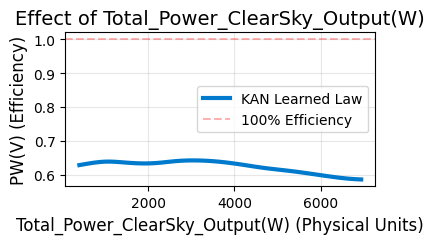

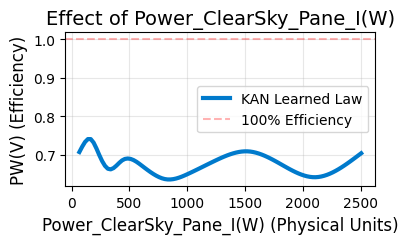

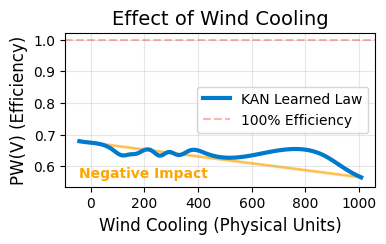

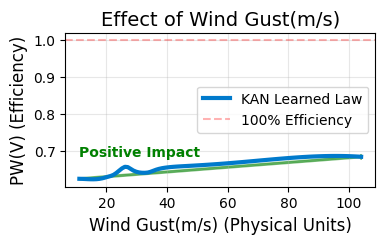

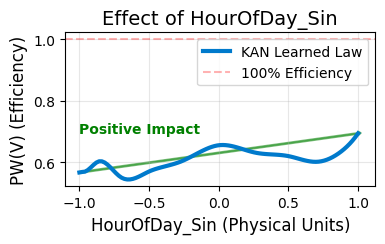

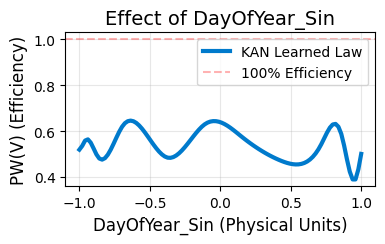

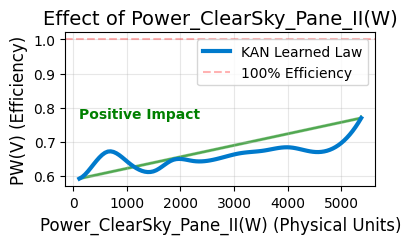

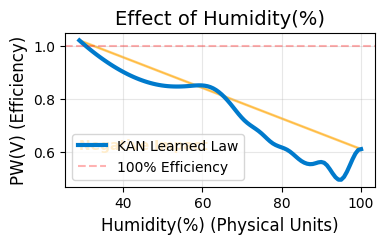

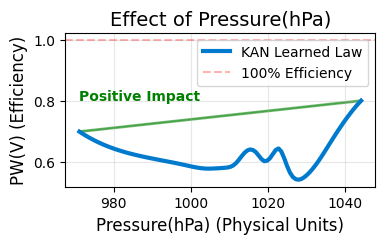

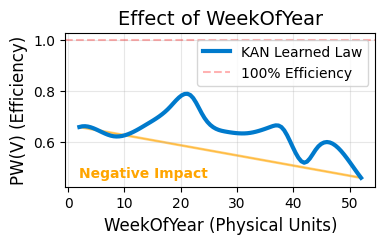

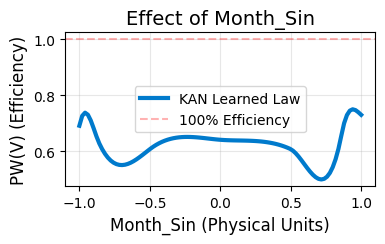

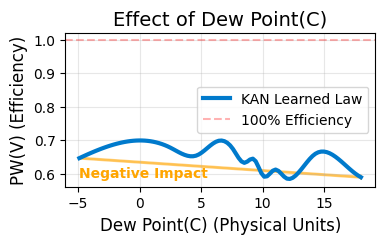

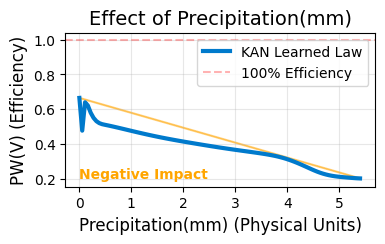

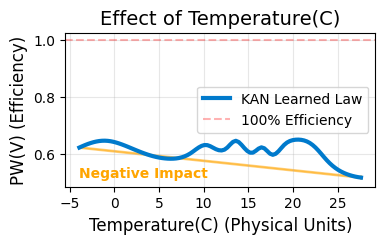

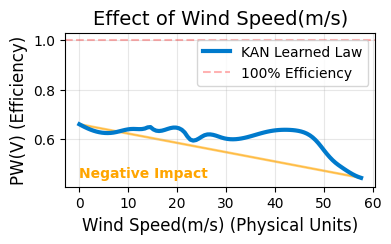

In [255]:
for feature in feature_cols:
    plot_kan_feature(model, feature, feature_cols, X_train, scaler_X)

## Export Metrics to CSV

Saves comprehensive performance metrics to CSV file including:
- Train and test metrics
- Both target-specific and PV(W) metrics
- Model configuration details
- Feature list for reproducibility

This enables:
- Comparison with ANN and FFKAN models
- Performance tracking across experiments
- Documentation for reports


In [256]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# Helper Functions for Metrics Calculation
# =========================================================

def calculate_metrics_for_target(y_true, y_pred, target_name="Target"):
    """Calculate comprehensive metrics for predictions"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Normalized metrics
    capacity = y_true.max()
    if capacity == 0:
        n_mae = 0
        n_rmse = 0
    else:
        n_mae = mae / capacity
        n_rmse = rmse / capacity
    accuracy = 1 - n_mae  # Simplified accuracy metric
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'n_rmse': n_rmse,
        'n_mae': n_mae,
        'n_rmse_pct': n_rmse * 100,
        'n_mae_pct': n_mae * 100,
        'accuracy': accuracy
    }
    
    print(f"\n{target_name} Metrics:")
    print(f"  RMSE:    {rmse:.2f}")
    print(f"  MAE:     {mae:.2f}")
    print(f"  R²:      {r2:.4f}")
    print(f"  N-RMSE:  {n_rmse:.4f} ({n_rmse*100:.2f}%)")
    print(f"  N-MAE:   {n_mae:.4f} ({n_mae*100:.2f}%)")
    print(f"  Accuracy: {accuracy:.4f}")
    
    return metrics

# =========================================================
# Get Predictions from the Model
# =========================================================

# Get predictions on test set
model.eval()
with torch.no_grad():
    test_input = dataset['test_input'].to(model.device)
    train_input = dataset['train_input'].to(model.device)
    y_pred_test_tensor = model(test_input)
    y_pred_train_tensor = model(train_input)

y_pred_test = y_pred_test_tensor.cpu().numpy()
y_pred_train = y_pred_train_tensor.cpu().numpy()

print(f"Predictions generated: test={y_pred_test.shape}, train={y_pred_train.shape}")

# =========================================================
# Extract Clearsky Values from Features
# =========================================================
# Find the index of 'Total_Power_ClearSky_Output(W)' in feature_cols
clearsky_index = feature_cols.index('Total_Power_ClearSky_Output(W)')

# Extract clearsky values from scaled features and inverse transform
clearsky_test_scaled = X_test_scaled[:, clearsky_index].reshape(-1, 1)
clearsky_train_scaled = X_train_scaled[:, clearsky_index].reshape(-1, 1)

# Create dummy arrays for inverse transform
dummy_test = np.zeros((X_test_scaled.shape[0], X_train.shape[1]))
dummy_test[:, clearsky_index] = clearsky_test_scaled.flatten()
clearsky_test = scaler_X.inverse_transform(dummy_test)[:, clearsky_index].reshape(-1, 1)

dummy_train = np.zeros((X_train_scaled.shape[0], X_train.shape[1]))
dummy_train[:, clearsky_index] = clearsky_train_scaled.flatten()
clearsky_train = scaler_X.inverse_transform(dummy_train)[:, clearsky_index].reshape(-1, 1)

print(f"Clearsky values extracted: test={clearsky_test.shape}, train={clearsky_train.shape}")

# =========================================================
# Calculate Metrics for Configured Target Column
# =========================================================
print("\n" + "="*60)
print(f"Metrics for Configured Target: {target_col}")
print("="*60)

# Apply physics constraints to predictions
y_pred_test_clipped = np.clip(y_pred_test, 0, None)
y_pred_train_clipped = np.clip(y_pred_train, 0, None)

test_metrics = calculate_metrics_for_target(y_test, y_pred_test_clipped, f"Test - {target_col}")
train_metrics = calculate_metrics_for_target(y_train, y_pred_train_clipped, f"Train - {target_col}")

# =========================================================
# Convert to PV(W) and Calculate PV(W) Metrics
# =========================================================
print("\n" + "="*60)
print("Converting to PV(W) and Calculating PV(W) Metrics")
print("="*60)

# Calculate PV(W) metrics
test_metrics_pvw = calculate_metrics_for_target(y_test_pvw, y_pred_test_pvw, "Test - PV(W)")
train_metrics_pvw = calculate_metrics_for_target(y_train_pvw, y_pred_train_pvw, "Train - PV(W)")

print("\n" + "="*60)
print("Metrics Calculation Complete")
print("="*60)

Predictions generated: test=(2194, 1), train=(2192, 1)
Clearsky values extracted: test=(2194, 1), train=(2192, 1)

Metrics for Configured Target: Clearsky_Index

Test - Clearsky_Index Metrics:
  RMSE:    0.25
  MAE:     0.20
  R²:      0.2042
  N-RMSE:  0.1337 (13.37%)
  N-MAE:   0.1052 (10.52%)
  Accuracy: 0.8948

Train - Clearsky_Index Metrics:
  RMSE:    0.22
  MAE:     0.17
  R²:      0.4439
  N-RMSE:  0.1418 (14.18%)
  N-MAE:   0.1125 (11.25%)
  Accuracy: 0.8875

Converting to PV(W) and Calculating PV(W) Metrics

Test - PV(W) Metrics:
  RMSE:    811.69
  MAE:     598.64
  R²:      0.6561
  N-RMSE:  0.1435 (14.35%)
  N-MAE:   0.1058 (10.58%)
  Accuracy: 0.8942

Train - PV(W) Metrics:
  RMSE:    651.92
  MAE:     483.07
  R²:      0.7898
  N-RMSE:  0.1149 (11.49%)
  N-MAE:   0.0852 (8.52%)
  Accuracy: 0.9148

Metrics Calculation Complete


## Save Trained Efficient KAN Model

Saves the complete model state using PyTorch's standard save format including:
- Model state dictionary (all learned weights)
- Optimizer state (for potential resume training)
- Training history (losses)

**File format**: `.pth` (PyTorch state dictionary)

This allows:
- Loading the model for predictions
- Resuming training if needed
- Model deployment

**Reference:**
- [PyTorch Model Saving](https://pytorch.org/tutorials/beginner/saving_loading_models.html)


In [257]:
# =========================================================
# Save Results to CSV
# =========================================================
import os


# Ensure results directory exists
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Model name
model_name = "KAN"

# CSV file path
csv_file = f'{results_dir}/{model_name.lower()}_test_metrics.csv'

# Prepare CSV line
with open(csv_file, 'a') as f:
    # If file is empty, write header
    if not os.path.exists(csv_file) or os.path.getsize(csv_file) == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train N-RMSE %', 'Train N-MAE %', 'Train Accuracy', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\\n')
    
    line = []
    line.append(model_name)
    line.append(str(test_no))
    line.append(f"{target_col}")
    line.append(f'"{test_name}"')  # Quote in case of commas
    line.append(f"{test_metrics['rmse']:.2f}")
    line.append(f"{test_metrics['mae']:.2f}")
    line.append(f"{test_metrics['r2']:.4f}")
    line.append(f"{test_metrics['n_rmse']:.4f}")
    line.append(f"{test_metrics['n_mae']:.4f}")
    line.append(f"{test_metrics['n_rmse_pct']:.4f}")
    line.append(f"{test_metrics['n_mae_pct']:.4f}")
    line.append(f"{test_metrics['accuracy']:.4f}")
    line.append(f"{train_metrics['rmse']:.2f}")
    line.append(f"{train_metrics['mae']:.2f}")
    line.append(f"{train_metrics['r2']:.4f}")
    line.append(f"{train_metrics['n_rmse']:.4f}")
    line.append(f"{train_metrics['n_mae']:.4f}")
    line.append(f"{train_metrics['n_rmse_pct']:.4f}")
    line.append(f"{train_metrics['n_mae_pct']:.4f}")
    line.append(f"{train_metrics['accuracy']:.4f}")
    line.append(f"{test_metrics_pvw['rmse']:.2f}")
    line.append(f"{test_metrics_pvw['mae']:.2f}")
    line.append(f"{test_metrics_pvw['r2']:.4f}")
    line.append(f"{test_metrics_pvw['n_rmse']:.4f}")
    line.append(f"{test_metrics_pvw['n_mae']:.4f}")
    line.append(f"{test_metrics_pvw['n_rmse_pct']:.4f}")
    line.append(f"{test_metrics_pvw['n_mae_pct']:.4f}")
    line.append(f"{test_metrics_pvw['accuracy']:.4f}")
    line.append(f"{train_metrics_pvw['rmse']:.2f}")
    line.append(f"{train_metrics_pvw['mae']:.2f}")
    line.append(f"{train_metrics_pvw['r2']:.4f}")
    line.append(f"{train_metrics_pvw['n_rmse']:.4f}")
    line.append(f"{train_metrics_pvw['n_mae']:.4f}")
    line.append(f"{train_metrics_pvw['accuracy']:.4f}")
    line.append(f"{train_metrics_pvw['n_rmse_pct']:.4f}")
    line.append(f"{train_metrics_pvw['n_mae_pct']:.4f}")
    line.append(f'"{notes}"')
    line.append(f'"feature_cols: {":".join(feature_cols)}"')
    f.write(','.join(line) + '\\n')

print(f"\\nResults saved to {csv_file}")


\nResults saved to results/kan_test_metrics.csv


__Save Model__

In [ ]:
# Save the trained model using PyTorch's standard save method
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
}, f"{MODEL_DIR}/efficient_kan_model_target.pth")
print(f"Model saved to {MODEL_DIR}/efficient_kan_model_target.pth")
